In [1]:
import ta
import requests
import numpy as np
import pandas as pd
import yfinance as yf
import FinanceDataReader as fdr
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import seaborn as sns
from yahooquery import Ticker
from fredapi import Fred
from datetime import datetime
from bs4 import BeautifulSoup
from pandas_datareader import data as pdr
from statsmodels.tsa.holtwinters import ExponentialSmoothing

import datetime as dt
import tensorflow as tf
import matplotlib.dates as mdates
import xgboost as xgb
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, learning_curve
from keras.regularizers import L1L2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import warnings

warnings.filterwarnings('ignore', category=UserWarning)

today = datetime.today().strftime('%Y-%m-%d')

In [9]:
ticker = 'aapl' 

In [5]:
file_path = '/Users/jongheelee/Desktop/JH/주가예측/data/tech_df.csv'  # 파일 경로 및 파일명
tech_df = pd.read_csv(file_path)
tech_df['Date'] = pd.to_datetime(tech_df['Date'])
tech_df.set_index('Date', inplace=True)

tech_df

,Open,High,Low,Close,Adj Close,Volume,MA5,MA20,MA60,MA120,...,EMA120,BOL_AVG,BOL_H1,BOL_L1,BOL_H2,BOL_L2,RSI,MACD,MACD_SIGNAL,OBV
Date,,,,,,,,,,,,,,,,,,,,,
2013-09-30,17.044643,17.202143,16.943214,17.026787,14.784490,260156400,NaN,NaN,NaN,NaN,...,14.784490,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,260156400
2013-10-01,17.087500,17.469286,17.084999,17.427143,15.132127,353883600,NaN,NaN,NaN,NaN,...,14.790236,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,614040000
2013-10-02,17.343929,17.564285,17.276787,17.484285,15.181746,289184000,NaN,NaN,NaN,NaN,...,14.796707,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,903224000
2013-10-03,17.518213,17.583929,17.169287,17.264643,14.991028,322753200,NaN,NaN,NaN,NaN,...,14.799919,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,580470800
2013-10-04,17.280714,17.307142,17.092857,17.251072,14.979237,258868400,15.013725,NaN,NaN,NaN,...,14.802883,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,321602400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-02,171.220001,174.300003,170.929993,173.750000,172.865433,52164500,170.734335,175.319870,181.646052,178.436223,...,175.220613,175.319870,184.220765,166.418975,179.770317,170.869423,44.066885,-2.570666,-2.302603,11078142400
2023-10-03,172.259995,173.630005,170.820007,172.399994,171.522293,49594600,170.821884,174.459274,181.381479,178.541822,...,175.159484,174.459274,180.882707,168.035840,177.670990,171.247557,41.822098,-2.507427,-2.343568,11028547800
2023-10-04,171.089996,174.210007,170.970001,173.660004,172.775894,53020300,171.464600,173.999128,181.146574,178.612723,...,175.120085,173.999128,179.390019,168.608237,176.694573,171.303683,44.655822,-2.329304,-2.340715,11081568100


In [6]:
## 1.1. Load data and Remove Missing value
df = tech_df.copy()

df = df.dropna()
df.isnull().sum() 

## 1.2. Apply MinMax Normalization
scaler = MinMaxScaler()
scale_cols = df.columns.tolist()
scaled_df = scaler.fit_transform(df[scale_cols])
scaled_df = pd.DataFrame(scaled_df, columns=scale_cols) 

# Define Input Parameter: feature, label -> numpy type
def make_sequene_dataset(feature, label, window_size):
    feature_list = []      
    label_list = []        
    for i in range(len(feature)-window_size):
        feature_list.append(feature[i:i+window_size]) 
        label_list.append(label[i+window_size]) 
    return np.array(feature_list), np.array(label_list) 

# Create feature_df, label_df 
feature_cols = df.columns.drop('Adj Close').tolist()
label_cols = [ 'Adj Close' ]

feature_df = pd.DataFrame(scaled_df, columns=feature_cols)
label_df = pd.DataFrame(scaled_df, columns=label_cols)

# DataFrame -> Numpy transform
feature_np = feature_df.to_numpy()
label_np = label_df.to_numpy()

print(f'feature_np.shape:{feature_np.shape}')
print(f'label_np.shape:{label_np.shape}')

feature_np.shape:(2404, 22)
label_np.shape:(2404, 1)


In [35]:
## 1.3. Create data    
# Set window size
window_size = 30
X, Y = make_sequene_dataset(feature_np, label_np, window_size)

# 3.2. Split into train, test (8:2)
split = int(len(X)*0.80) 
x_train = X[0:split]
y_train = Y[0:split]

x_test = X[split:]
y_test = Y[split:]

print(f'X.shape:{X.shape}, Y.shape:{Y.shape}')
print(f'x_train.shape:{x_train.shape}, y_train.shape:{y_train.shape}')
print(f'x_test.shape:{x_test.shape}, y_test.shape:{y_test.shape}') 

X.shape: (2488, 30, 19), Y.shape: (2488, 1)
x_train.shape: (1990, 30, 19), y_train.shape: (1990, 1)
x_val.shape: (249, 30, 19), y_val.shape: (249, 1)
x_test.shape: (249, 30, 19), y_test.shape: (249, 1)


In [36]:
## 1.4. Construct and Compile model
model = Sequential()

model.add(LSTM(64, activation='tanh', input_shape=x_train[0].shape, return_sequences=False, 
               kernel_regularizer=L1L2(l1=0.0001, l2=0.0001), recurrent_regularizer=L1L2(l1=0.0001, l2=0.0001)))
model.add(Dropout(0.2))

model.add(Dense(1, activation='linear'))

model.compile(loss='mse', optimizer='adam', metrics=['mae'])

model.summary()

# List to record the loss values during the model training process
train_loss_history = []
val_loss_history = []

# Train model (Apply earlystopping)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

hist = model.fit(x_train, y_train, 
          validation_data=(x_test, y_test),
          epochs=1000, batch_size=150,       
          callbacks=[early_stop]) 

pred = model.predict(x_test)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 64)             │        21,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,569 (84.25 KB)

 Trainable params: 21,569 (84.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.2897 - mae: 0.3043 - val_loss: 0.1980 - val_mae: 0.2622
Epoch 2/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1325 - mae: 0.0826 - val_loss: 0.1767 - val_mae: 0.2214
Epoch 3/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1207 - mae: 0.0662 - val_loss: 0.1833 - val_mae: 0.2530
Epoch 4/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1107 - mae: 0.0577 - val_loss: 0.1707 - val_mae: 0.2446
Epoch 5/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1016 - mae: 0.0543 - val_loss: 0.1703 - val_mae: 0.2576
Epoch 6/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0939 - mae: 0.0530 - val_loss: 0.1461 - val_mae: 0.2224
Epoch 7/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0862 - mae: 0.0491 - val_loss: 0.1521 - val_mae: 0.2488
Epoch 8/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0799 - mae: 0.0495 - val_loss: 0.1406 - val_mae: 0.2377
Epoch 9/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/

In [19]:
inverse_df = pd.DataFrame(np.zeros((len(y_test), len(scale_cols))), columns=scale_cols) 
inverse_df['Adj Close'] = y_test.flatten()
real_y_test = scaler.inverse_transform(inverse_df)[:, inverse_df.columns.get_loc('Adj Close')]

inverse_df['Adj Close'] = pred.flatten() 
real_pred = scaler.inverse_transform(inverse_df)[:, inverse_df.columns.get_loc('Adj Close')]

dates = df.index[split+window_size:].values 

tech_result_df = pd.DataFrame({
    'Date': dates,
    'Real Price': real_y_test,
    'Predicted Price': real_pred
})

tech_result_df

,Date,Real Price,Predicted Price
0,2021-11-16,148.729828,143.218561
1,2021-11-17,151.182388,143.423601
2,2021-11-18,155.496536,144.122346
3,2021-11-19,158.136246,145.446790
4,2021-11-22,158.599197,147.148698
...,...,...,...
470,2023-10-02,172.865433,165.605932
471,2023-10-03,171.522293,165.573552
472,2023-10-04,172.775894,165.423620
473,2023-10-05,174.019516,165.423140


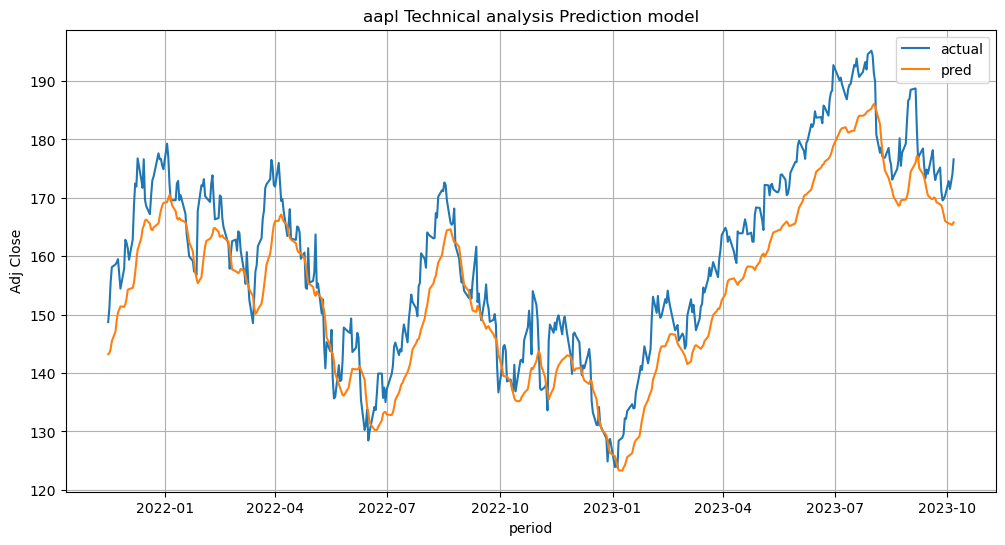

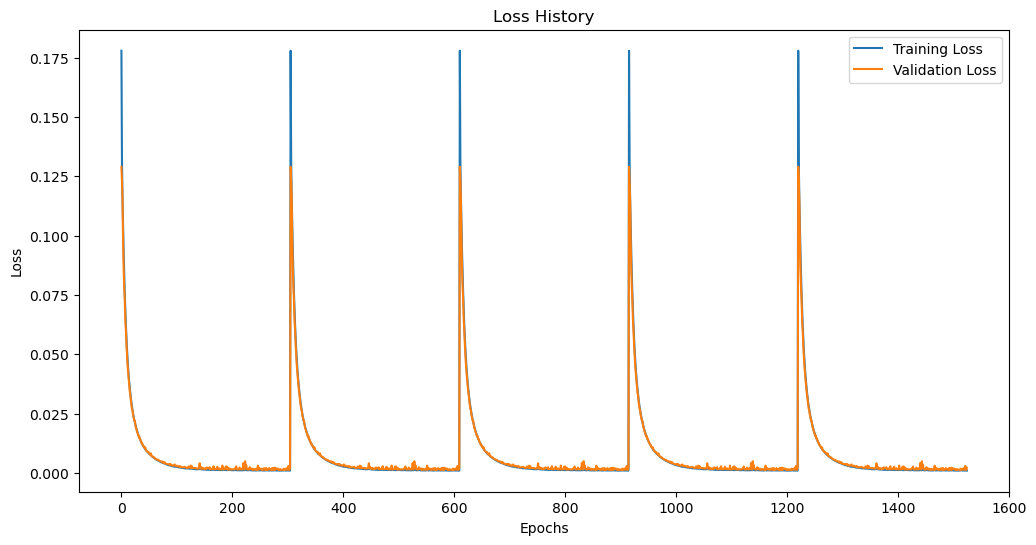

  Metrics    Values
0    MAPE  0.042844
1     MAE  0.034779
2    RMSE  0.040484


In [21]:
# Evaluation 1: Prediction Graph
plt.figure(figsize=(12, 6))
plt.title(f'{ticker} Technical analysis Prediction model')
plt.ylabel('Adj Close')
plt.xlabel('period')
plt.plot(tech_result_df['Date'], tech_result_df['Real Price'], label='actual')
plt.plot(tech_result_df['Date'], tech_result_df['Predicted Price'], label='pred')
plt.grid()
plt.legend(loc='best')
plt.show()

# Evaluation 2: Learning Curve
train_loss_history.extend(hist.history['loss']) 
val_loss_history.extend(hist.history['val_loss'])

plt.figure(figsize=(12, 6))
plt.plot(train_loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.legend()
plt.title('Loss History')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Evaluation 2: MAPE, MAE, RMSE
mape = np.sum(abs(y_test - pred) / y_test) / len(x_test)
mae = np.mean(np.abs(y_test - pred))
rmse = np.sqrt(np.mean(np.square(y_test - pred)))

metrics_df = pd.DataFrame({
    'Metrics': ['MAPE', 'MAE', 'RMSE'],
    'Values': [mape, mae, rmse]})

print(metrics_df)

In [24]:
last_date = pd.to_datetime(df.index[-1]) 

if last_date.weekday() == 4:  
    next_day = last_date + pd.Timedelta(days=3)  
else:
    next_day = last_date + pd.Timedelta(days=1)  

# 1. Extract the last 30 days data
recent_feature = feature_np[-window_size:]
recent_feature = recent_feature.reshape(1, window_size, -1)

# 2. Predict the value for the next day
predicted_new = model.predict(recent_feature)

# 3. Inverse transform the predicted value to its original scale
dummy_data = np.zeros((1, scaled_df.shape[1] - 1))
predicted_new_full_features = np.hstack([predicted_new, dummy_data])

tech_predicted_new_original = scaler.inverse_transform(predicted_new_full_features)[0, 0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


# 2. Fund

In [23]:
file_path = '/Users/jongheelee/Desktop/JH/주가예측/data/fund_df.csv'  # 파일 경로 및 파일명
fund_df = pd.read_csv(file_path)
fund_df['Date'] = pd.to_datetime(fund_df['Date'])
fund_df.set_index('Date', inplace=True)

fund_df

,2-year,5-year,10-year,T10Y2Y,VIXCLS,UNRATE,CPIAUCSL,FEDFUNDS,GDP,DJI Adj Close,DJI Volume,NDAQ Adj Close,NDAQ Volume,SPX Adj Close,SPX Volume,RUT Adj Close,RUT Volume,Adj Close,Information Technology Adj Close,Information Technology Volume
Date,,,,,,,,,,,,,,,,,,,,
2013-09-30,0.33,1.39,2.64,2.31,16.60,7.200000,233.663318,0.089545,17188.410197,15129.669922,122330000,3771.479980,1895760000,1681.550049,3308630000,1073.790039,3308630000,14.784490,72.227211,380600
2013-10-01,0.33,1.42,2.66,2.33,15.54,7.200000,233.669000,0.090000,17192.019000,15191.700195,82460000,3817.979980,1843320000,1695.000000,3238690000,1087.430054,3238690000,15.132127,72.996910,160200
2013-10-02,0.31,1.38,2.63,2.32,16.60,7.186957,233.687739,0.089565,17192.105652,15133.139648,86090000,3815.020020,1792980000,1693.869995,3148600000,1082.550049,3148600000,15.181746,73.023750,350700
2013-10-03,0.33,1.36,2.62,2.29,17.67,7.173913,233.706478,0.089130,17192.192303,14996.480469,91300000,3774.340088,1884340000,1678.660034,3279650000,1070.900024,3279650000,14.991028,72.254066,216800
2013-10-04,0.33,1.41,2.66,2.33,16.74,7.160870,233.725217,0.088696,17192.278955,15072.580078,75100000,3807.750000,1549600000,1690.500000,2880270000,1078.250000,2880270000,14.979237,72.746300,456100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-25,5.09,4.62,4.55,-0.54,16.90,3.800000,307.482400,5.330000,27935.652154,34006.878906,229450000,13271.320312,4100290000,4337.439941,3195650000,1784.239990,3195650000,175.183578,413.726105,1057400
2023-09-26,5.04,4.62,4.56,-0.48,18.94,3.800000,307.494550,5.330000,27940.988615,33618.878906,280100000,13063.610352,4693540000,4273.529785,3472340000,1761.609985,3472340000,171.084549,406.341705,533500
2023-09-27,5.10,4.67,4.61,-0.49,18.22,3.800000,307.506700,5.330000,27946.325077,33550.269531,300330000,13092.849609,4841410000,4274.509766,3875880000,1778.900024,3875880000,169.562317,407.592285,584900


In [25]:
df = fund_df.copy()

df = df.dropna()
df.isnull().sum() 

## 2.2. Apply MinMax Normalization
scaler = MinMaxScaler()
scale_cols = df.columns.tolist()
scaled_df = scaler.fit_transform(df[scale_cols])
scaled_df = pd.DataFrame(scaled_df, columns=scale_cols) 

# Define Input Parameter: feature, label -> numpy type
def make_sequene_dataset(feature, label, window_size):
    feature_list = []      
    label_list = []        
    for i in range(len(feature)-window_size):
        feature_list.append(feature[i:i+window_size]) 
        label_list.append(label[i+window_size]) 
    return np.array(feature_list), np.array(label_list) 

# feature_df, label_df 생성
feature_cols = df.columns.drop('Adj Close').tolist()
label_cols = [ 'Adj Close' ]

feature_df = pd.DataFrame(scaled_df, columns=feature_cols)
label_df = pd.DataFrame(scaled_df, columns=label_cols)

# DataFrame -> Numpy transformation
feature_np = feature_df.to_numpy()
label_np = label_df.to_numpy()

print(f'feature_np.shape:{feature_np.shape}')
print(f'label_np.shape:{label_np.shape}')

feature_np.shape:(2518, 19)
label_np.shape:(2518, 1)


In [26]:
## 2.3. Create data    
# Set window size
window_size = 30
X, Y = make_sequene_dataset(feature_np, label_np, window_size)


# 3.2. Split into train, test (8:2)
split = int(len(X)*0.80) 
x_train = X[0:split]
y_train = Y[0:split]

x_test = X[split:]
y_test = Y[split:]

print(f'X.shape:{X.shape}, Y.shape:{Y.shape}')
print(f'x_train.shape:{x_train.shape}, y_train.shape:{y_train.shape}')
print(f'x_test.shape:{x_test.shape}, y_test.shape:{y_test.shape}') 

X.shape:(2488, 30, 19), Y.shape:(2488, 1)
x_train.shape:(1990, 30, 19), y_train.shape:(1990, 1)
x_test.shape:(498, 30, 19), y_test.shape:(498, 1)


In [27]:
## 2.4. Construct and Compile model
model = Sequential()

model.add(LSTM(128, activation='tanh', input_shape=x_train[0].shape, return_sequences=True,
               kernel_regularizer=L1L2(l1=0.001, l2=0.001), recurrent_regularizer=L1L2(l1=0.001, l2=0.001)))
               
model.add(Dropout(0.2))

model.add(LSTM(64, activation='tanh'))
model.add(Dropout(0.2))

model.add(Dense(1, activation='linear'))

model.compile(loss='mse', optimizer='adam', metrics=['mae'])

model.summary()

# List to record the loss values during the model training process
train_loss_history = []
val_loss_history = []

# Train model (Apply earlystopping)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

hist = model.fit(x_train, y_train, 
          validation_data=(x_test, y_test),
          epochs=1000, batch_size=150,       
          callbacks=[early_stop]) 

pred = model.predict(x_test)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 30, 128)        │        75,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 125,249 (489.25 KB)

 Trainable params: 125,249 (489.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 2.8303 - mae: 0.1749 - val_loss: 2.2543 - val_mae: 0.3116
Epoch 2/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 1.9572 - mae: 0.0463 - val_loss: 1.6191 - val_mae: 0.3837
Epoch 3/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 1.3233 - mae: 0.0348 - val_loss: 1.0867 - val_mae: 0.3307
Epoch 4/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.8650 - mae: 0.0315 - val_loss: 0.7248 - val_mae: 0.3063
Epoch 5/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.5500 - mae: 0.0297 - val_loss: 0.4879 - val_mae: 0.2979
Epoch 6/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.3415 - mae: 0.0279 - val_loss: 0.3420 - val_mae: 0.2985
Epoch 7/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.2114 - mae: 0.0277 - val_loss: 0.2472 - val_mae: 0.2871
Epoch 8/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.1340 - mae: 0.0263 - val_loss: 0.1998 - val_mae: 0.2886
Epoch 9/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/

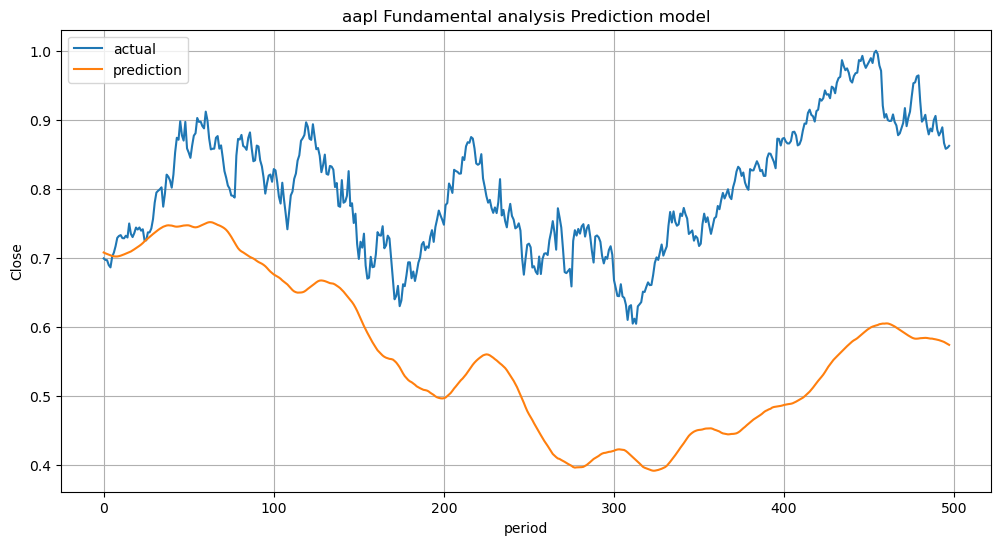

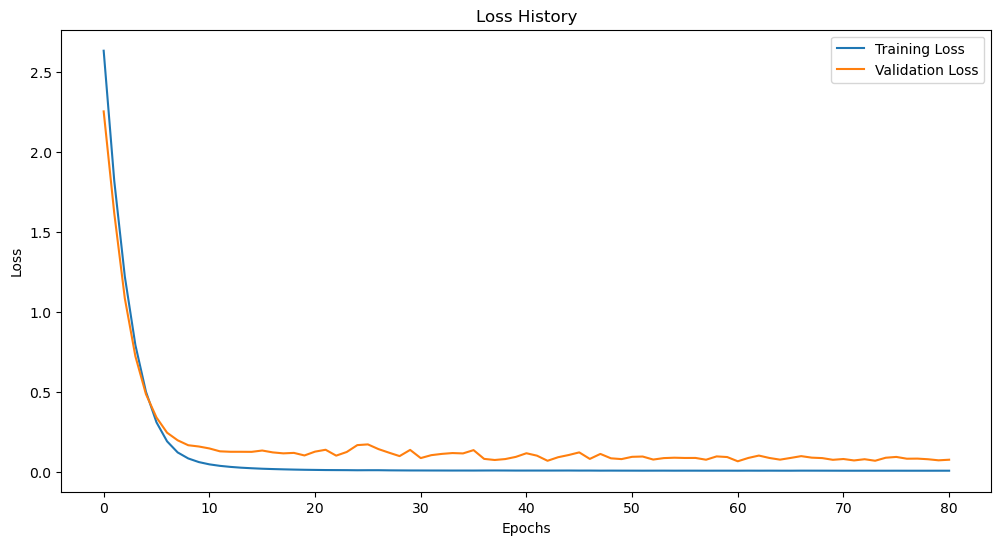

  Metrics    Values
0    MAPE  0.296883
1     MAE  0.238815
2    RMSE  0.263580


In [28]:
# Evaluation 1: Prediction Graph
plt.figure(figsize=(12, 6))
plt.title(f'{ticker} Fundamental analysis Prediction model')
plt.ylabel('Close')
plt.xlabel('period')
plt.plot(y_test, label='actual')
plt.plot(pred, label='prediction')
plt.grid()
plt.legend(loc='best')
plt.show()


# Evaluation 2: Learning Curve
train_loss_history.extend(hist.history['loss']) 
val_loss_history.extend(hist.history['val_loss'])

plt.figure(figsize=(12, 6))
plt.plot(train_loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.legend()
plt.title('Loss History')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()


# Evaluation 3: MAPE, MAE, RMSE
mape = np.sum(abs(y_test - pred) / y_test) / len(x_test)
mae = np.mean(np.abs(y_test - pred))
rmse = np.sqrt(np.mean(np.square(y_test - pred)))

metrics_df = pd.DataFrame({
    'Metrics': ['MAPE', 'MAE', 'RMSE'],
    'Values': [mape, mae, rmse]})

print(metrics_df)


In [29]:
inverse_df = pd.DataFrame(np.zeros((len(y_test), len(scale_cols))), columns=scale_cols) 
inverse_df['Adj Close'] = y_test.flatten()
real_y_test = scaler.inverse_transform(inverse_df)[:, inverse_df.columns.get_loc('Adj Close')]

inverse_df['Adj Close'] = pred.flatten() 
real_pred = scaler.inverse_transform(inverse_df)[:, inverse_df.columns.get_loc('Adj Close')]

dates = df.index[split+window_size:].values 

fund_result_df = pd.DataFrame({
    'Date': dates,
    'Real Price': real_y_test,
    'Predicted Price': real_pred
})

In [30]:
last_date = pd.to_datetime(df.index[-1]) 

if last_date.weekday() == 4:  
    next_day = last_date + pd.Timedelta(days=3) 
else:
    next_day = last_date + pd.Timedelta(days=1) 

# 1. Extract the last 50 days data
latest_data = feature_np[-window_size:]
latest_data = latest_data.reshape(1, window_size, -1)

# 2. Predict the value for the next day
next_day_pred = model.predict(latest_data)

# 3. Inverse transform the predicted value to its original scale
inverse_df_temp = pd.DataFrame(np.zeros((1, len(scale_cols))), columns=scale_cols)  
inverse_df_temp['Adj Close'] = next_day_pred.flatten()
fund_predicted_new_original = scaler.inverse_transform(inverse_df_temp)[:, inverse_df_temp.columns.get_loc('Adj Close')]

# Convert numpy array value to scalar
fund_predicted_new_original = fund_predicted_new_original.item()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


# 3. 최종 Stacking

In [31]:
# 1. Create dataframe based on each analysis result
df = pd.merge(tech_result_df[['Date', 'Real Price', 'Predicted Price']], 
                     fund_result_df[['Date', 'Predicted Price']],
                     on='Date', 
                     how='inner', 
                     suffixes=('_Tech', '_Fund'))

df.columns = ['Date', 'Real Price', 'Tech_Pred', 'Fund_Pred'] # Rename Column
df = df.set_index('Date').sort_index()

# 2. Apply MinMax Normalization
scaler = MinMaxScaler()
scale_cols = ['Real Price', 'Tech_Pred', 'Fund_Pred']
scaled_df = scaler.fit_transform(df[scale_cols])
scaled_df = pd.DataFrame(scaled_df, columns=scale_cols) 

# Create Feature/Label for Stacking model
X_stack = scaled_df[['Tech_Pred', 'Fund_Pred']].values
y_stack = scaled_df['Real Price'].values

# 3. Data split (20% test)
X_train, X_val, y_train, y_val = train_test_split(X_stack, y_stack, test_size=0.2, random_state=42)

print(f'X_train.shape:{X_train.shape}, X_val.shape:{X_val.shape}')
print(f'y_train.shape:{y_train.shape}, y_val.shape:{y_val.shape}') 

X_train.shape:(376, 2), X_val.shape:(94, 2)
y_train.shape:(376,), y_val.shape:(94,)


In [32]:
# 4. Meta model training using XGBoost with GridSearchCV
model = xgb.XGBRegressor(objective='reg:squarederror')

param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.8, 0.9],
    'n_estimators': [50, 100],
    'gamma': [0, 0.1, 0.2],
    'min_child_weight': [1, 5, 10],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0.5, 1, 1.5]
}

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(f"Best parameters found: {best_params}")

# Train the model with best parameters
meta_model_xgb = xgb.XGBRegressor(objective='reg:squarederror', **best_params)
meta_model_xgb.fit(X_train, y_train)

y_pred = meta_model_xgb.predict(X_val)

Best parameters found: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 10, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 0.9}


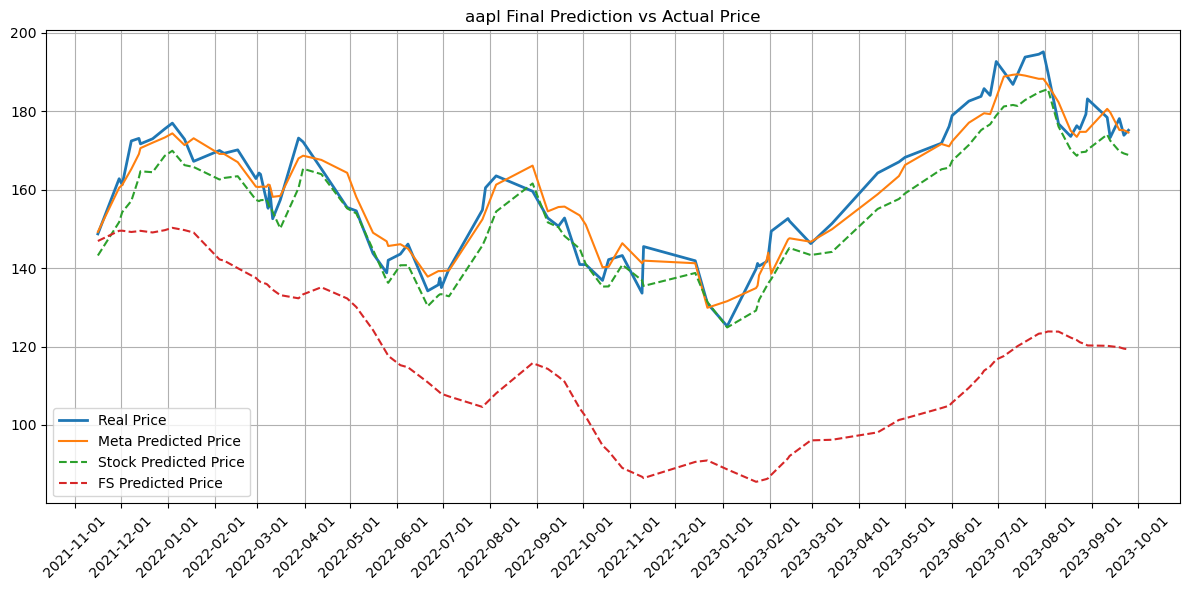

In [33]:
# Extracting predicted values from scaled data
y_val_original = scaler.inverse_transform(np.column_stack([y_val, np.zeros_like(y_val), np.zeros_like(y_val)]))[:, 0]
y_pred_original = scaler.inverse_transform(np.column_stack([y_pred, np.zeros_like(y_pred), np.zeros_like(y_pred)]))[:, 0]
tech_pred_original = scaler.inverse_transform(np.column_stack([np.zeros_like(y_pred), X_val[:, 0], np.zeros_like(y_pred)]))[:, 1]
fund_pred_original = scaler.inverse_transform(np.column_stack([np.zeros_like(y_pred), np.zeros_like(y_pred), X_val[:, 1]]))[:, 2]

# Extracting date index
date_train, date_val = train_test_split(df.index, test_size=0.2, random_state=42)

# Prediction Graph
plot_df = pd.DataFrame({
    'Date': date_val,
    'Real Price': y_val_original,
    'Meta Predicted Price': y_pred_original,
    'Stock Predicted Price': tech_pred_original,
    'FS Predicted Price': fund_pred_original
})

plot_df = plot_df.sort_values(by='Date')
plot_df['Date'] = pd.to_datetime(plot_df['Date'])

plt.figure(figsize=(12, 6))
plt.plot(plot_df['Date'], plot_df['Real Price'], label='Real Price', linewidth=2)
plt.plot(plot_df['Date'], plot_df['Meta Predicted Price'], label='Meta Predicted Price', linewidth=1.5)
plt.plot(plot_df['Date'], plot_df['Stock Predicted Price'], '--', label='Stock Predicted Price', linewidth=1.5)
plt.plot(plot_df['Date'], plot_df['FS Predicted Price'], '--', label='FS Predicted Price', linewidth=1.5)

ax = plt.gca() 
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1)) 
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  

plt.title(f"{ticker} Final Prediction vs Actual Price")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  
plt.tight_layout()  